In [2]:
# Importación de las librerias necesarias
import geopandas as gpd
import pandas as pd
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
# VARIABLES DEPENDIENTE DEL ENTORNO
user_code = 'u519914'
data_path = '/us/'+user_code+'/lava_iniciative/data/'

# Rutas de ficheros origen
ine_shp = data_path + 'in/INE_SHP/SECC_CPV_E_20111101_01_R_INE.shp'
madiva_csv = data_path + 'in/madiva_geo.csv'
geojson_dir = data_path + 'in/geojson_overpass/'
#ine_csv = data_path + 'in/datos_ine_censo_final.csv'
ine_csv = data_path + 'result/datos_ine_agregados.csv'
cbd_csv = data_path + 'tmp/CBD/cbd_distance.csv'

# Rutas de ficheros intermedios

economic_data = data_path + 'tmp/economic_data2.csv'
economic_area = data_path + 'tmp/economic_area.csv'

# Rutas de ficheros de salida

#raw_dataframe_csv = data_path + 'tmp/raw_dataframe.csv'
final_dataframe_csv = data_path + 'result/final_dataframe.csv'

# 1. Cargamos el dataframe final y las proyecciones 

In [4]:
# CARGAMOS LOS DATOS DE LOS FICHEROS GENERADO PREVIAMENTE

In [47]:
# Datos de geolocalización y precio (madrid y barcelona)
df_ine_madiva = gpd.read_file('/us/'+user_code+'/lava_iniciative/data/result/shp_ine_madiva/ine_madiva.shp', encoding='utf8')
df_ine_madiva = df_ine_madiva[((df_ine_madiva['CPRO']=='28') & (df_ine_madiva['CMUN']=='079'))|((df_ine_madiva['CPRO']=='08') & (df_ine_madiva['CMUN']=='019'))]
df_ine_madiva = df_ine_madiva[['CUSEC','geometry', 'euros_m2_r']]

In [222]:
# Cargamos los datos del CSV obtenidos del dato transaccional
filename = '/us/u519914/lava_iniciative/data/tmp/economic_data2.csv'
dfVariables = pd.read_csv(filename, sep=";", decimal=",")
dfVariables['ssccs'] = dfVariables['ssccs'].apply(lambda x: "%010d" % + x)

In [223]:
# Nos quedamos con las columnas de numero de operaciones y numero de comercios (eliminamos la de precio)
l_variables = dfVariables.columns[:20].append(dfVariables.columns[39:])
dfNumTr = dfVariables[l_variables]

In [224]:
df_ine_madiva.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3185 entries, 4184 to 20101
Data columns (total 3 columns):
CUSEC         3185 non-null object
geometry      3185 non-null object
euros_m2_r    3184 non-null float64
dtypes: float64(1), object(2)
memory usage: 99.5+ KB


In [225]:
dfNumTr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 39 columns):
ssccs                          3459 non-null object
es_auto                        3459 non-null int64
es_bank                        3459 non-null int64
es_barsandrestaurants          3459 non-null int64
es_bbva                        3459 non-null int64
es_contents                    3459 non-null int64
es_fashion                     3459 non-null int64
es_food                        3459 non-null int64
es_health                      3459 non-null int64
es_home                        3459 non-null int64
es_hotelservices               3459 non-null int64
es_hyper                       3459 non-null int64
es_leisure                     3459 non-null int64
es_otherservices               3459 non-null int64
es_propertyservices            3459 non-null int64
es_sportsandtoys               3459 non-null int64
es_tech                        3459 non-null int64
es_transportation        

In [226]:
# Sacamos la información de las columnas eliminando la sección censal
c_values = dfNumTr.columns[1:]
print c_values

Index([u'es_auto', u'es_bank', u'es_barsandrestaurants', u'es_bbva',
       u'es_contents', u'es_fashion', u'es_food', u'es_health', u'es_home',
       u'es_hotelservices', u'es_hyper', u'es_leisure', u'es_otherservices',
       u'es_propertyservices', u'es_sportsandtoys', u'es_tech',
       u'es_transportation', u'es_travel', u'es_wellnessandbeauty',
       u'es_auto_count', u'es_bank_count', u'es_barsandrestaurants_count',
       u'es_bbva_count', u'es_contents_count', u'es_fashion_count',
       u'es_food_count', u'es_health_count', u'es_home_count',
       u'es_hotelservices_count', u'es_hyper_count', u'es_leisure_count',
       u'es_otherservices_count', u'es_propertyservices_count',
       u'es_sportsandtoys_count', u'es_tech_count', u'es_transportation_count',
       u'es_travel_count', u'es_wellnessandbeauty_count'],
      dtype='object')


In [39]:
#df_ine_madiva['geometry'].apply(lambda x: x.centroid.buffer(0.001))

In [237]:
# Metodo para la generacion de un data frame con la agregación de variables indicadas
def aggregationVarGeneration(geodf, datadf, l_indexname, r_indexname, listvalues, distance):
    if distance > 0:
        df_in = geodf
        df_in['geometry'] = geodf['geometry'].apply(lambda x: x.centroid.buffer(distance))
        df_groups = gpd.sjoin(geodf,geodf,how='left', op='intersects', lsuffix='l', rsuffix='aux')
        df_groups = df_groups.merge(datadf, how='left', left_on=l_indexname+'_aux', right_on=r_indexname)
        #return df_groups
        aggs = df_groups.groupby([l_indexname+'_l'])[listvalues].sum()
        aggs = aggs.reindex(aggs.index.rename(['ssccs']))
        return aggs
    else:
        df_groups = geodf.merge(datadf, how='left', left_on=l_indexname, right_on=r_indexname)
        aggs = df_groups.groupby([l_indexname])[listvalues].sum()
        aggs = aggs.reindex(aggs.index.rename(['ssccs']))
        return aggs
    

In [274]:
def reviewCorrelation(df_data, df_precio):
    df_data['CUSEC'] = df_data.index.values
    df_data_p = df_data.merge(df_precio, on='CUSEC')
    df_data_p = df_data_p.drop('CUSEC', axis = 1) 
    df_data_p = df_data_p[~df_data_p['euros_m2_r'].isnull()]
    df_data_p = df_data_p.fillna(0)
    R = corrcoef(df_data_p.T)
    dfR = pd.DataFrame(R, columns = df_data_p.columns, index = df_data_p.columns)
    return dfR

## Vamos a realizar una agregación por distancia y revisar la correlación de estas variables con el precio

In [275]:
df_0m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0)
dfR = reviewCorrelation(df_0m, df_precio)
#cor = dfR.iloc[-1:,:-1].T
#cor = cor.rename(columns={'euros_m2_r':'0m'})
cor_aux = dfR.iloc[-1:,:-1].T
cor['0m'] = cor_aux['euros_m2_r']

In [164]:
df_250m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.00225)
dfR = reviewCorrelation(df_250m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['250m'] = cor_aux['euros_m2_r']

In [165]:
df_500m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.0045)
dfR = reviewCorrelation(df_500m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['500m'] = cor_aux['euros_m2_r']

In [276]:
cor

0m      250m      500m     1000m     1500m  \
es_auto                      0.063368  0.215912  0.347871  0.497804  0.554807   
es_bank                      0.044445  0.121813  0.247085  0.412462  0.496463   
es_barsandrestaurants        0.246091  0.479019  0.540971  0.635955  0.684484   
es_bbva                      0.131830  0.346358  0.480428  0.589378  0.632673   
es_contents                  0.060255  0.218341  0.313281  0.491051  0.565954   
es_fashion                   0.102633  0.236796  0.362971  0.558611  0.628634   
es_food                      0.106243  0.264731  0.325112  0.374558  0.414459   
es_health                    0.207131  0.438499  0.555880  0.633390  0.642710   
es_home                      0.087820  0.318741  0.428251  0.515681  0.548278   
es_hotelservices             0.171593  0.326070  0.424587  0.573836  0.658922   
es_hyper                     0.055037  0.175688  0.319371  0.539048  0.562732   
es_leisure                   0.056507  0.171951  0.255788  0.412592  0.552956   
es_otherservices             0.114881  0.320446  0.462264  0.604332  0.657260   
es_propertyservices          0.094928  0.240635  0.371175  0.530985  0.604348   
es_sportsandtoys             0.052901  0.170816  0.271692  0.447927  0.505475   
es_tech                      0.086523  0.278008  0.452516  0.616502  0.666526   
es_transportation            0.004546  0.045272  0.177273  0.349044  0.394010   
es_travel                    0.015942  0.131215  0.260593  0.431367  0.479190   
es_wellnessandbeauty         0.225134  0.447663  0.561308  0.666201  0.685676   
es_auto_count                0.072280  0.179668  0.272248  0.421358  0.520297   
es_bank_count                0.012763  0.089729  0.196674  0.371003  0.499207   
es_barsandrestaurants_count  0.377472  0.470697  0.512983  0.600980  0.650179   
es_bbva_count                0.160618  0.377862  0.508540  0.596532  0.638439   
es_contents_count            0.285421  0.442044  0.511301  0.599563  0.651499   
es_fashion_count             0.277122  0.400156  0.495228  0.607321  0.642805   
es_food_count                0.163905  0.330926  0.417793  0.495037  0.529582   
es_health_count              0.417547  0.515774  0.590376  0.657841  0.667381   
es_home_count                0.259418  0.412017  0.496708  0.569360  0.600225   
es_hotelservices_count       0.167805  0.237024  0.295089  0.445827  0.548548   
es_hyper_count               0.129308  0.310790  0.442341  0.575580  0.586223   
es_leisure_count             0.162414  0.344223  0.431604  0.541686  0.609220   
es_otherservices_count       0.363590  0.493665  0.548728  0.630340  0.661053   
es_propertyservices_count    0.196174  0.372475  0.441258  0.526990  0.585829   
es_sportsandtoys_count       0.271043  0.462098  0.562024  0.646548  0.664712   
es_tech_count                0.216190  0.352162  0.441675  0.538559  0.583615   
es_transportation_count     -0.081484 -0.291068 -0.268317 -0.158128 -0.022175   
es_travel_count              0.217091  0.424521  0.499393  0.604536  0.648115   
es_wellnessandbeauty_count   0.407875  0.487625  0.562384  0.636511  0.656502   

                                2000m     3000m     4000m  
es_auto                      0.577565  0.542429  0.468220  
es_bank                      0.507688  0.367900  0.119647  
es_barsandrestaurants        0.698123  0.617233  0.492498  
es_bbva                      0.640645  0.544510  0.395359  
es_contents                  0.606082  0.540367  0.482232  
es_fashion                   0.652014  0.542530  0.436497  
es_food                      0.440755  0.448765  0.433357  
es_health                    0.641547  0.579184  0.503837  
es_home                      0.546219  0.466655  0.413154  
es_hotelservices             0.678406  0.569744  0.390555  
es_hyper                     0.539193  0.420449  0.245583  
es_leisure                   0.599208  0.523780  0.397209  
es_otherservices             0.664943  0.580320  0.502492  
es_propertyservices          0.6304

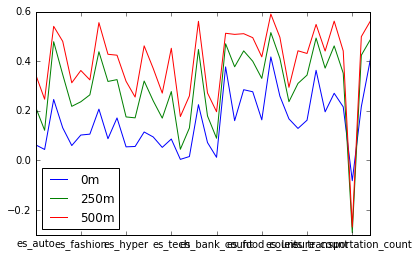

In [277]:
cor[['0m','250m','500m']].plot()

## Observamos que la correlación con el precio mejora considerando un radio mayor.
#### Como es gratis.... pues vamos a echar cuentas con otros radios  mayores.

In [287]:
df_1000m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.009)
dfR = reviewCorrelation(df_1000m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['1000m'] = cor_aux['euros_m2_r']

In [168]:
df_1500m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.0135)
dfR = reviewCorrelation(df_1500m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['1500m'] = cor_aux['euros_m2_r']

In [169]:
df_2000m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.018)
dfR = reviewCorrelation(df_2000m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['2000m'] = cor_aux['euros_m2_r']

In [278]:
cor

0m      250m      500m     1000m     1500m  \
es_auto                      0.063368  0.215912  0.347871  0.497804  0.554807   
es_bank                      0.044445  0.121813  0.247085  0.412462  0.496463   
es_barsandrestaurants        0.246091  0.479019  0.540971  0.635955  0.684484   
es_bbva                      0.131830  0.346358  0.480428  0.589378  0.632673   
es_contents                  0.060255  0.218341  0.313281  0.491051  0.565954   
es_fashion                   0.102633  0.236796  0.362971  0.558611  0.628634   
es_food                      0.106243  0.264731  0.325112  0.374558  0.414459   
es_health                    0.207131  0.438499  0.555880  0.633390  0.642710   
es_home                      0.087820  0.318741  0.428251  0.515681  0.548278   
es_hotelservices             0.171593  0.326070  0.424587  0.573836  0.658922   
es_hyper                     0.055037  0.175688  0.319371  0.539048  0.562732   
es_leisure                   0.056507  0.171951  0.255788  0.412592  0.552956   
es_otherservices             0.114881  0.320446  0.462264  0.604332  0.657260   
es_propertyservices          0.094928  0.240635  0.371175  0.530985  0.604348   
es_sportsandtoys             0.052901  0.170816  0.271692  0.447927  0.505475   
es_tech                      0.086523  0.278008  0.452516  0.616502  0.666526   
es_transportation            0.004546  0.045272  0.177273  0.349044  0.394010   
es_travel                    0.015942  0.131215  0.260593  0.431367  0.479190   
es_wellnessandbeauty         0.225134  0.447663  0.561308  0.666201  0.685676   
es_auto_count                0.072280  0.179668  0.272248  0.421358  0.520297   
es_bank_count                0.012763  0.089729  0.196674  0.371003  0.499207   
es_barsandrestaurants_count  0.377472  0.470697  0.512983  0.600980  0.650179   
es_bbva_count                0.160618  0.377862  0.508540  0.596532  0.638439   
es_contents_count            0.285421  0.442044  0.511301  0.599563  0.651499   
es_fashion_count             0.277122  0.400156  0.495228  0.607321  0.642805   
es_food_count                0.163905  0.330926  0.417793  0.495037  0.529582   
es_health_count              0.417547  0.515774  0.590376  0.657841  0.667381   
es_home_count                0.259418  0.412017  0.496708  0.569360  0.600225   
es_hotelservices_count       0.167805  0.237024  0.295089  0.445827  0.548548   
es_hyper_count               0.129308  0.310790  0.442341  0.575580  0.586223   
es_leisure_count             0.162414  0.344223  0.431604  0.541686  0.609220   
es_otherservices_count       0.363590  0.493665  0.548728  0.630340  0.661053   
es_propertyservices_count    0.196174  0.372475  0.441258  0.526990  0.585829   
es_sportsandtoys_count       0.271043  0.462098  0.562024  0.646548  0.664712   
es_tech_count                0.216190  0.352162  0.441675  0.538559  0.583615   
es_transportation_count     -0.081484 -0.291068 -0.268317 -0.158128 -0.022175   
es_travel_count              0.217091  0.424521  0.499393  0.604536  0.648115   
es_wellnessandbeauty_count   0.407875  0.487625  0.562384  0.636511  0.656502   

                                2000m     3000m     4000m  
es_auto                      0.577565  0.542429  0.468220  
es_bank                      0.507688  0.367900  0.119647  
es_barsandrestaurants        0.698123  0.617233  0.492498  
es_bbva                      0.640645  0.544510  0.395359  
es_contents                  0.606082  0.540367  0.482232  
es_fashion                   0.652014  0.542530  0.436497  
es_food                      0.440755  0.448765  0.433357  
es_health                    0.641547  0.579184  0.503837  
es_home                      0.546219  0.466655  0.413154  
es_hotelservices             0.678406  0.569744  0.390555  
es_hyper                     0.539193  0.420449  0.245583  
es_leisure                   0.599208  0.523780  0.397209  
es_otherservices             0.664943  0.580320  0.502492  
es_propertyservices          0.6304

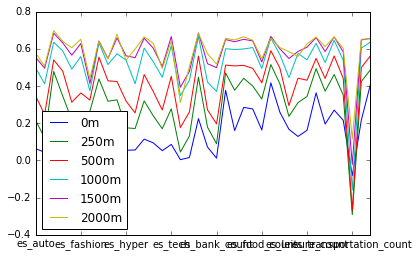

In [279]:
cor[['0m','250m','500m','1000m','1500m','2000m']].plot()

### Parece que llega a un limite de los 1.5 km a 2 no hay diferencia....Solo por comprobar, vamos a ver si empeora al seguir aumentando

In [280]:
df_3000m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.027)
dfR = reviewCorrelation(df_3000m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['3000m'] = cor_aux['euros_m2_r']

In [281]:
df_4000m = aggregationVarGeneration(df_ine_madiva, dfNumTr, 'CUSEC', 'ssccs',c_values, 0.036)
dfR = reviewCorrelation(df_4000m, df_precio)
cor_aux = dfR.iloc[-1:,:-1].T
cor['4000m'] = cor_aux['euros_m2_r']

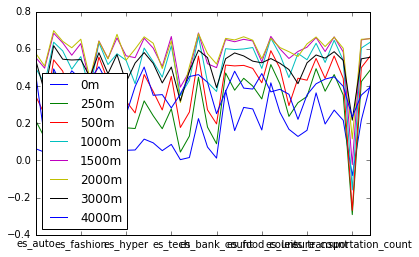

In [282]:
cor.plot()

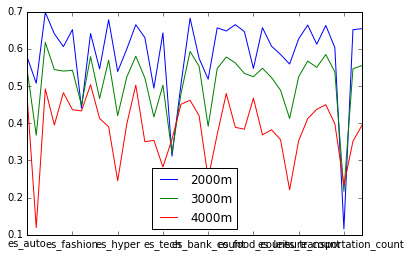

In [283]:
# muchas lineas....
cor[['2000m','3000m','4000m']].plot()

#### Aqui ya se observa que al aumentar el radio vamos perdiendo correlación, lo cual tiene sentido por que los valores se van igualando
Si hablamos solo con respecto a correlaciones con el precio, parece que 1 o 1.5KM vuelve a ser lo más relevante

In [298]:
filename = '/us/u519914/lava_iniciative/data/tmp/economic_data3.csv'
df_500m.to_csv(filename, sep=";", decimal=".",index=False)

# ALTERNATIVA DE VISUALIZACION

In [92]:
from numpy import corrcoef, sum, log, arange
from numpy.random import rand
from pylab import pcolor, show, colorbar, xticks, yticks

dfR = pd.DataFrame(R, columns = df_500m_p.columns, index = df_500m_p.columns)

In [100]:
dfR.to_csv(data_path + '/tmp/corr_matrix.csv')

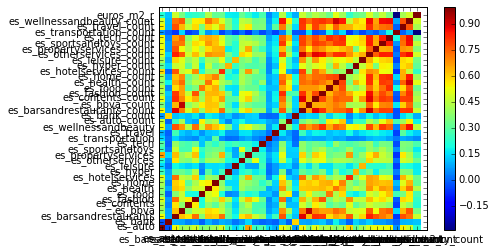

In [97]:
pcolor(R)
colorbar()
yticks(arange(0.5,39.5),df_500m_p.columns)
xticks(arange(0.5,39.5),df_500m_p.columns)
show()